# Predicting Boston Housing Prices

## Using XGBoost in SageMaker (Deploy)

_Deep Learning Nanodegree Program | Deployment_

---

As an introduction to using SageMaker's High Level Python API we will look at a relatively simple problem. Namely, we will use the [Boston Housing Dataset](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html) to predict the median value of a home in the area of Boston Mass.

The documentation for the high level API can be found on the [ReadTheDocs page](http://sagemaker.readthedocs.io/en/latest/)

## General Outline

Typically, when using a notebook instance with SageMaker, you will proceed through the following steps. Of course, not every step will need to be done with each project. Also, there is quite a lot of room for variation in many of the steps, as you will see throughout these lessons.

1. Download or otherwise retrieve the data.
2. Process / Prepare the data.
3. Upload the processed data to S3.
4. Train a chosen model.
5. Test the trained model (typically using a batch transform job).
6. Deploy the trained model.
7. Use the deployed model.

In this notebook we will be skipping step 5, testing the model. We will still test the model but we will do so by first deploying the model and then sending the test data to the deployed model.

In [1]:
# Make sure that we use SageMaker 1.x
!pip install sagemaker==1.72.0

     |████████████████████████████████| 297 kB 11.3 MB/s eta 0:00:01
  Created wheel for sagemaker: filename=sagemaker-1.72.0-py2.py3-none-any.whl size=386358 sha256=8ae44966829d9cce46c44e3abef363343d59d0646fbf389753b47954defb1e89
  Stored in directory: /home/ec2-user/.cache/pip/wheels/c3/58/70/85faf4437568bfaa4c419937569ba1fe54d44c5db42406bbd7
Successfully built sagemaker
  Attempting uninstall: smdebug-rulesconfig
    Found existing installation: smdebug-rulesconfig 1.0.0
    Uninstalling smdebug-rulesconfig-1.0.0:
      Successfully uninstalled smdebug-rulesconfig-1.0.0
  Attempting uninstall: sagemaker
    Found existing installation: sagemaker 2.19.0
    Uninstalling sagemaker-2.19.0:
      Successfully uninstalled sagemaker-2.19.0
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.


## Step 0: Setting up the notebook

We begin by setting up all of the necessary bits required to run our notebook. To start that means loading all of the Python modules we will need.

In [2]:
%matplotlib inline

import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.datasets import load_boston
import sklearn.model_selection

In addition to the modules above, we need to import the various bits of SageMaker that we will be using. 

In [3]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.predictor import csv_serializer

# This is an object that represents the SageMaker session that we are currently operating in. This
# object contains some useful information that we will need to access later such as our region.
session = sagemaker.Session()

# This is an object that represents the IAM role that we are currently assigned. When we construct
# and launch the training job later we will need to tell it what IAM role it should have. Since our
# use case is relatively simple we will simply assign the training job the role we currently have.
role = get_execution_role()

## Step 1: Downloading the data

Fortunately, this dataset can be retrieved using sklearn and so this step is relatively straightforward.

In [4]:
boston = load_boston()

## Step 2: Preparing and splitting the data

Given that this is clean tabular data, we don't need to do any processing. However, we do need to split the rows in the dataset up into train, test and validation sets.

In [5]:
# First we package up the input data and the target variable (the median value) as pandas dataframes. This
# will make saving the data to a file a little easier later on.

X_bos_pd = pd.DataFrame(boston.data, columns=boston.feature_names)
Y_bos_pd = pd.DataFrame(boston.target)

# We split the dataset into 2/3 training and 1/3 testing sets.
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X_bos_pd, Y_bos_pd, test_size=0.33)

# Then we split the training set further into 2/3 training and 1/3 validation sets.
X_train, X_val, Y_train, Y_val = sklearn.model_selection.train_test_split(X_train, Y_train, test_size=0.33)

## Step 3: Uploading the training and validation files to S3

When a training job is constructed using SageMaker, a container is executed which performs the training operation. This container is given access to data that is stored in S3. This means that we need to upload the data we want to use for training to S3. We can use the SageMaker API to do this and hide some of the details.

### Save the data locally

First we need to create the train and validation csv files which we will then upload to S3.

In [6]:
# This is our local data directory. We need to make sure that it exists.
data_dir = '../data/boston'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [7]:
# We use pandas to save our train and validation data to csv files. Note that we make sure not to include header
# information or an index as this is required by the built in algorithms provided by Amazon. Also, it is assumed
# that the first entry in each row is the target variable.

pd.concat([Y_val, X_val], axis=1).to_csv(os.path.join(data_dir, 'validation.csv'), header=False, index=False)
pd.concat([Y_train, X_train], axis=1).to_csv(os.path.join(data_dir, 'train.csv'), header=False, index=False)

### Upload to S3

Since we are currently running inside of a SageMaker session, we can use the object which represents this session to upload our data to the 'default' S3 bucket. Note that it is good practice to provide a custom prefix (essentially an S3 folder) to make sure that you don't accidentally interfere with data uploaded from some other notebook or project.

In [8]:
prefix = 'boston-xgboost-deploy-hl'

val_location = session.upload_data(os.path.join(data_dir, 'validation.csv'), key_prefix=prefix)
train_location = session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)

## Step 4: Train the XGBoost model

Now that we have the training and validation data uploaded to S3, we can construct our XGBoost model and train it. We will be making use of the high level SageMaker API to do this which will make the resulting code a little easier to read at the cost of some flexibility.

To construct an estimator, the object which we wish to train, we need to provide the location of a container which contains the training code. Since we are using a built in algorithm this container is provided by Amazon. However, the full name of the container is a bit lengthy and depends on the region that we are operating in. Fortunately, SageMaker provides a useful utility method called `get_image_uri` that constructs the image name for us.

To use the `get_image_uri` method we need to provide it with our current region, which can be obtained from the session object, and the name of the algorithm we wish to use. In this notebook we will be using XGBoost however you could try another algorithm if you wish. The list of built in algorithms can be found in the list of [Common Parameters](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-algo-docker-registry-paths.html).

In [9]:
# As stated above, we use this utility method to construct the image name for the training container.
container = get_image_uri(session.boto_region_name, 'xgboost')

# Now that we know which container to use, we can construct the estimator object.
xgb = sagemaker.estimator.Estimator(container, # The name of the training container
                                    role,      # The IAM role to use (our current role in this case)
                                    train_instance_count=1, # The number of instances to use for training
                                    train_instance_type='ml.m4.xlarge', # The type of instance ot use for training
                                    output_path='s3://{}/{}/output'.format(session.default_bucket(), prefix),
                                                                        # Where to save the output (the model artifacts)
                                    sagemaker_session=session) # The current SageMaker session

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
There is a more up to date SageMaker XGBoost image. To use the newer image, please set 'repo_version'='1.0-1'. For example:
	get_image_uri(region, 'xgboost', '1.0-1').
Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


Before asking SageMaker to begin the training job, we should probably set any model specific hyperparameters. There are quite a few that can be set when using the XGBoost algorithm, below are just a few of them. If you would like to change the hyperparameters below or modify additional ones you can find additional information on the [XGBoost hyperparameter page](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost_hyperparameters.html)

In [10]:
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        objective='reg:linear',
                        early_stopping_rounds=10,
                        num_round=200)

Now that we have our estimator object completely set up, it is time to train it. To do this we make sure that SageMaker knows our input data is in csv format and then execute the `fit` method.

In [11]:
# This is a wrapper around the location of our train and validation data, to make sure that SageMaker
# knows our data is in csv format.
s3_input_train = sagemaker.s3_input(s3_data=train_location, content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data=val_location, content_type='csv')

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


2020-12-29 22:48:57 Starting - Starting the training job...
2020-12-29 22:49:00 Starting - Launching requested ML instances......
2020-12-29 22:50:16 Starting - Preparing the instances for training......
2020-12-29 22:51:12 Downloading - Downloading input data...
2020-12-29 22:51:42 Training - Downloading the training image..Arguments: train
[2020-12-29:22:52:03:INFO] Running standalone xgboost training.
[2020-12-29:22:52:03:INFO] File size need to be processed in the node: 0.02mb. Available memory size in the node: 8450.22mb
[2020-12-29:22:52:03:INFO] Determined delimiter of CSV input is ','
[22:52:03] S3DistributionType set as FullyReplicated
[22:52:03] 227x13 matrix with 2951 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2020-12-29:22:52:03:INFO] Determined delimiter of CSV input is ','
[22:52:03] S3DistributionType set as FullyReplicated
[22:52:03] 112x13 matrix with 1456 entries loaded from /opt/ml/input/data/validation?format=csv&label_column


2020-12-29 22:52:15 Uploading - Uploading generated training model
2020-12-29 22:52:15 Completed - Training job completed
Training seconds: 63
Billable seconds: 63


## Step 5: Test the trained model

We will be skipping this step for now. We will still test our trained model but we are going to do it by using the deployed model, rather than setting up a batch transform job.


## Step 6: Deploy the trained model

Now that we have fit our model to the training data, using the validation data to avoid overfitting, we can deploy our model and test it. Deploying is very simple when we use the high level API, we need only call the `deploy` method of our trained estimator.

**NOTE:** When deploying a model you are asking SageMaker to launch an compute instance that will wait for data to be sent to it. As a result, this compute instance will continue to run until *you* shut it down. This is important to know since the cost of a deployed endpoint depends on how long it has been running for.

In other words **If you are no longer using a deployed endpoint, shut it down!**

In [12]:
xgb_predictor = xgb.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


---------------!

## Step 7: Use the model

Now that our model is trained and deployed we can send the test data to it and evaluate the results. Here, because our test data is so small, we can send it all using a single call to our endpoint. If our test dataset was larger we would need to split it up and send the data in chunks, making sure to accumulate the results.

In [13]:
# We need to tell the endpoint what format the data we are sending is in
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer

Y_pred = xgb_predictor.predict(X_test.values).decode('utf-8')
# predictions is currently a comma delimited string and so we would like to break it up
# as a numpy array.
Y_pred = np.fromstring(Y_pred, sep=',')

To see how well our model works we can create a simple scatter plot between the predicted and actual values. If the model was completely accurate the resulting scatter plot would look like the line $x=y$. As we can see, our model seems to have done okay but there is room for improvement.

Text(0.5, 1.0, 'Median Price vs Predicted Price')

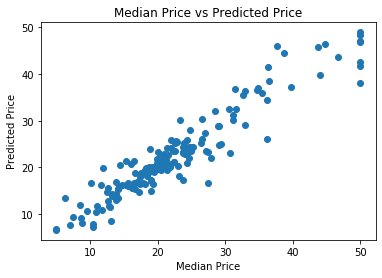

In [14]:
plt.scatter(Y_test, Y_pred)
plt.xlabel("Median Price")
plt.ylabel("Predicted Price")
plt.title("Median Price vs Predicted Price")

## Delete the endpoint

Since we are no longer using the deployed model we need to make sure to shut it down. Remember that you have to pay for the length of time that your endpoint is deployed so the longer it is left running, the more it costs.

In [15]:
xgb_predictor.delete_endpoint()

## Optional: Clean up

The default notebook instance on SageMaker doesn't have a lot of excess disk space available. As you continue to complete and execute notebooks you will eventually fill up this disk space, leading to errors which can be difficult to diagnose. Once you are completely finished using a notebook it is a good idea to remove the files that you created along the way. Of course, you can do this from the terminal or from the notebook hub if you would like. The cell below contains some commands to clean up the created files from within the notebook.

In [16]:
# First we will remove all of the files contained in the data_dir directory
!rm $data_dir/*

# And then we delete the directory itself
!rmdir $data_dir